<a href="https://colab.research.google.com/github/QuantumQist/Toy-Problems/blob/main/Fourier_transform_1D_noise_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple 1D noise removal with Fourier transform.

We perform a simple analysis of noise removal of Fourier transform.

We consider 1-dimensional signals and see how the Fourier transform can help with taking care of small amount of noise.

In [200]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 1D signal with no noise

In this section, we take our signal to be

$$ f(t) = \sin(2 \pi f t) $$

with $f= 5 \text{Hz}$.

In [201]:
import numpy as np

def f(t, f = 5):
  """
  Returns the signal.
  t can be either a float or a list of floats.
  """
  return np.sin(2 * np.pi * f  * t)

Let's generate signal starting at t = 0 and ending at $t=1$. Let's say we have $n=500$ points in the signal.

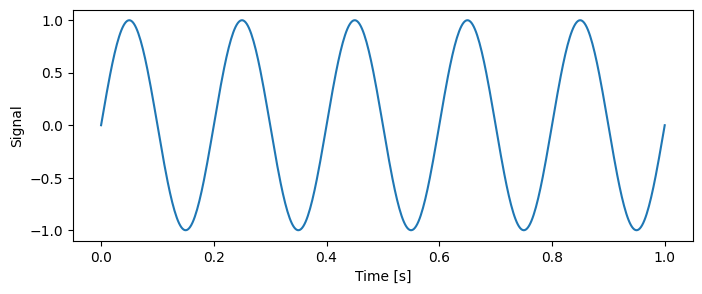

In [202]:
NUM_POINTS = 500

t_list = np.linspace(start = 0, stop = 1, num = NUM_POINTS)
signal = f(t_list)
# Plot the signal
plt.figure(figsize = (8,3))
plt.xlabel("Time [s]")
plt.ylabel("Signal")
plt.plot(t_list, signal);

Apply Fourier transform to the signal and plot the output. We use `numpy.fft.rfft()` istead of `numpy.fft.fft()` since we have a real signal.

We will also need the sample frequencies  - arguments for Fourier-transformed signal. We get them from `np.fft.rfftfreq(n, d)`. The arguments of the function are
* `n` number of points used to compute the transfomr.
* `d` spacing between points

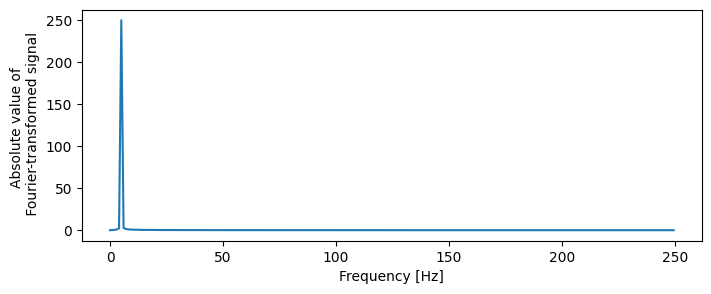

In [203]:
# Get sample frequencies
frequencies = np.fft.rfftfreq( n = NUM_POINTS,
                              d = t_list[1] - t_list[0] )

# Compute Fourier transform
signal_after_fourier_transform = np.fft.rfft(signal)
# Plot total Fourier transform
plt.figure(figsize = (8,3))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Absolute value of \n Fourier-transformed signal")
plt.plot(frequencies, np.abs(signal_after_fourier_transform));

Note that in the plot above we plot the **absolute value** of the Fourier transform, not the direct output. We do it to gain information about the magnitude of the elements, not just the real value of the transformed function.

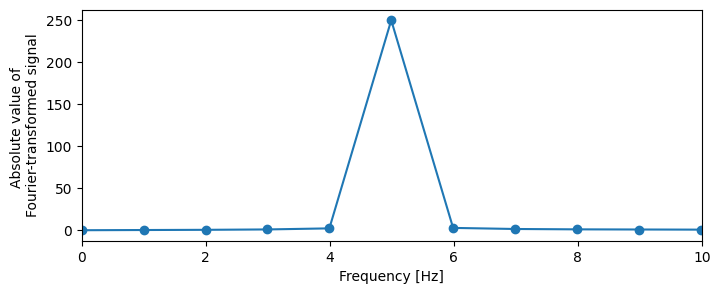

In [204]:
# Plot Fourier transform near the region where it's non-zero.
plt.figure(figsize = (8,3))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Absolute value of \nFourier-transformed signal")
plt.xlim((0,10))
plt.plot(frequencies, np.abs(signal_after_fourier_transform), "-o");

Note that the Fourier transform is non-zero in the region near $f=5\text{Hz}$. For an infinite signal, the Fourier transform of a $\sin$ function is Dirac delta, the difference results from a finite signal.

## 2. Plane wave signal with noise.

We will take the same signal as before, but this time we will add noise. For every $t$ we will take $ɛ$ from a normal distribution of zero mean and variance $\sigma = 2$. The final signal will be

$$f_{ɛ}(t) = f(t) + ɛ = sin(2 \pi f t) + ɛ,$$

where $ɛ$ is the added noise.

Let's define a function that adds noise to the original signal.

In [206]:
def add_noise_to_signal(signal, noise_std):
  """
  Adds noise to the signal.

  Parameters:
  * signal: list of floats
    Original signal
  * noise_std: float
    Standard deviation of the normal distribution used to generate the noise.

  Returns the signal with added noise.
  """
  # Generate noise
  noise = np.random.normal(
      scale = noise_std,
      size = len(signal)
  )
  return signal + noise

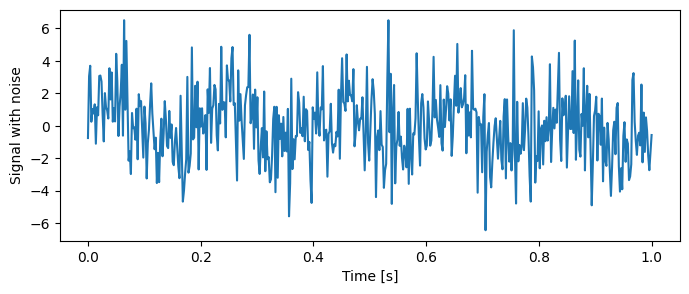

In [207]:
# Add noise to signal and plot the result
signal_with_noise = add_noise_to_signal(signal = signal, noise_std = 2.)
# Plot the noisy signal
plt.figure(figsize = (8,3))
plt.xlabel("Time [s]")
plt.ylabel("Signal with noise")
plt.plot(t_list, signal_with_noise);

Compute the Fourier transform of the noisy signal and plot the result.

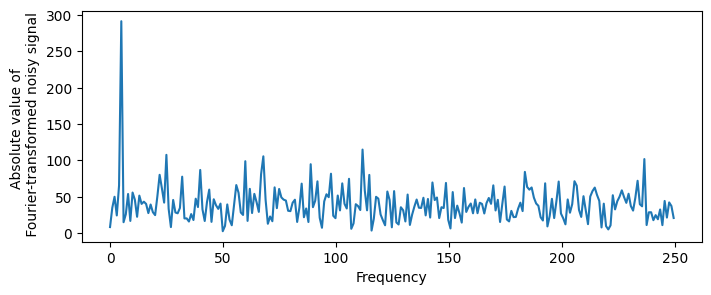

In [208]:
# Compute Fourier transform
fft_signal_with_noise = np.fft.rfft(signal_with_noise)
# Plot the result
plt.figure(figsize = (8,3))
plt.xlabel("Frequency")
plt.ylabel("Absolute value of \n Fourier-transformed noisy signal")
plt.plot(frequencies, np.abs(fft_signal_with_noise));

Observe the high-frequency component near $5\text{Hz}$. We will filter this component by setting the other Fourier coefficients to $0$.

To achieve it, we will define the function `filter_fft()` that takes the Fourier transform as input and sets all elemenents below certain threshold to 0.

In [209]:
def filter_fft(fourier_transformed_signal, threshold = None):
  """
  Filters the `fourier_transformed_signal` by setting all elements
  below `threshold` to zero.

  If threshold is not provided, we filter the values below half of the maximum.
  """
  # Copy `fourier_transformed_signal`
  filtered_fft = fourier_transformed_signal.copy()

  # Check if threshold was provided
  if threshold is None:
    threshold = 0.5 * np.max(np.abs(fourier_transformed_signal))

  for idx, element in enumerate(filtered_fft):
    if np.abs(element) < threshold:
      filtered_fft[idx] = 0.

  return filtered_fft

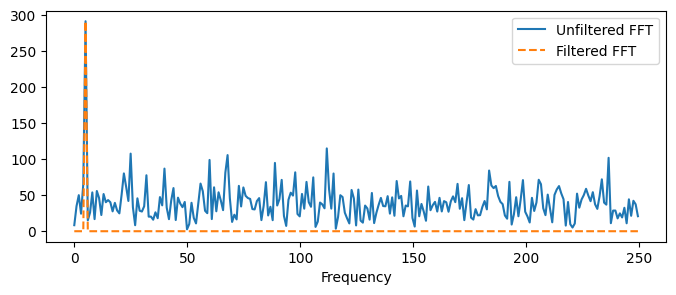

In [210]:
# Filter the noisy Fouriee transform
filtered_fft_signal_with_noise = filter_fft(fft_signal_with_noise)

# Plot the result
plt.figure(figsize = (8,3))
plt.xlabel("Frequency")
plt.plot(frequencies, np.abs(fft_signal_with_noise), label="Unfiltered FFT")
plt.plot(frequencies, np.abs(filtered_fft_signal_with_noise),  "--", label="Filtered FFT")
plt.legend()

Filtering out was successful!

Now let's perform inverse Fourier transform on `filtered_fft_signal_with_noise` and compare it to the original wave.

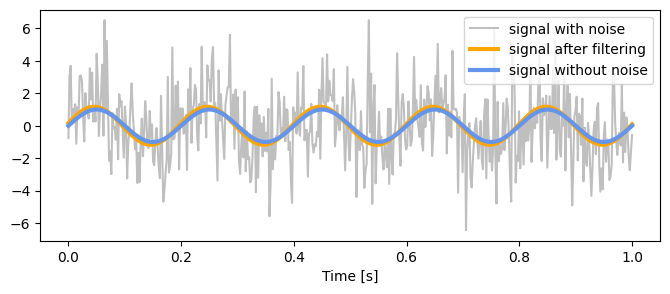

In [211]:
denoised_signal = np.fft.irfft(filtered_fft_signal_with_noise)

# Plot the noisy signal
plt.figure(figsize = (8,3))
plt.xlabel("Time [s]")
plt.plot(t_list, signal_with_noise, label = "signal with noise", color = "gray", alpha = 0.5);
plt.plot(t_list, denoised_signal, label = "signal after filtering", linewidth = 3, color = "orange");
plt.plot(t_list, signal, label = "signal without noise", linewidth = 3, color = "cornflowerblue" );
plt.legend();

It worked pretty good!

### 3. Signal composed of 3 plane waves.

Let's perform a similar workflow as in the provious section for the signal

$$ g(t) = 2\sin(20 \cdot 2\pi t) + \sin(30 \cdot 2\pi t) + \cos(50 \cdot 2\pi t).$$

We have 3 waves in the signal with frequencies $f_1 = 20\text{Hz}$, $f_2=30\text{Hz}$, $f_2=50\text{Hz}$ and amplitudes $A_1 = 2$, $A_2 = 1$, $A_3=1$.

In [212]:
def g(t):
  return 2*np.sin(20*2*np.pi*t) + np.sin(30*2*np.pi*t) + np.cos(50*2*np.pi*t)

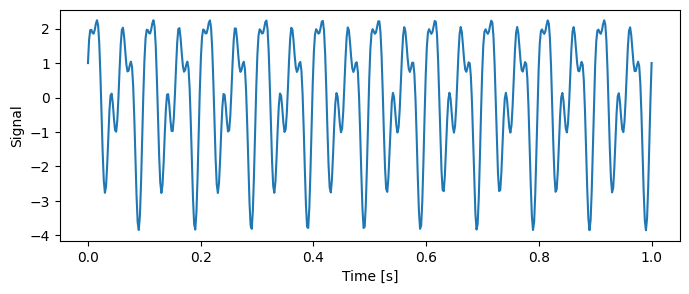

In [213]:
signal = g(t_list)

# Plot the signal
plt.figure(figsize = (8,3))
plt.xlabel("Time [s]")
plt.ylabel("Signal")
plt.plot(t_list, signal);

Generate noisy signal and plot it.

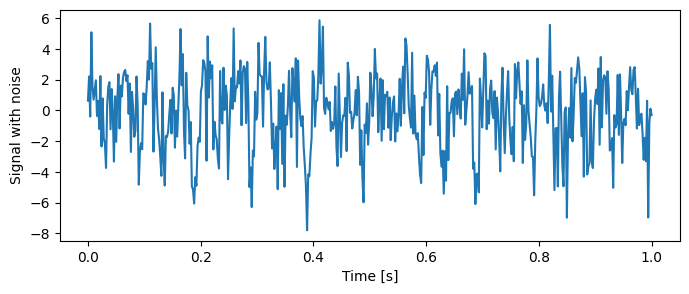

In [214]:
# Add noise to signal and plot the result
signal_with_noise = add_noise_to_signal(signal = signal, noise_std = 2.)
# Plot the noisy signal
plt.figure(figsize = (8,3))
plt.xlabel("Time [s]")
plt.ylabel("Signal with noise")
plt.plot(t_list, signal_with_noise);

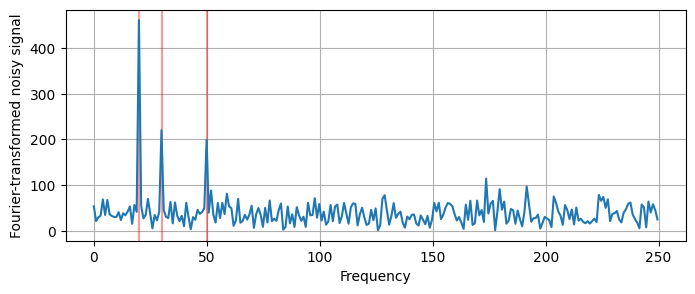

In [217]:
# Compute Fourier transform
fft_signal_with_noise = np.fft.rfft(signal_with_noise)
# Plot the result
plt.figure(figsize = (8,3))
plt.xlabel("Frequency")
plt.ylabel("Fourier-transformed noisy signal")
for freq in [20, 30, 50]:
  plt.axvline(x = freq, color = "red", alpha = 0.4)
plt.grid()
plt.plot(frequencies, np.abs(fft_signal_with_noise));

The red lines in the plot above indicate the frequencies used to generate the original signal. We can see clear peaks there. Let's apply filter on Fourier-transformed signal.

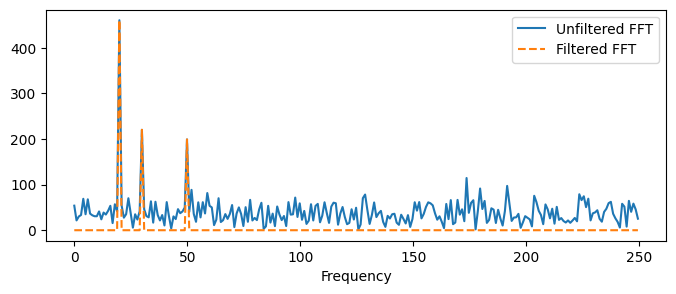

In [219]:
# Filter the noisy Fouriee transform
filtered_fft_signal_with_noise = filter_fft(fft_signal_with_noise, threshold = 150)

# Plot the result
plt.figure(figsize = (8,3))
plt.xlabel("Frequency")
plt.plot(frequencies, np.abs(fft_signal_with_noise), label="Unfiltered FFT")
plt.plot(frequencies, np.abs(filtered_fft_signal_with_noise),  "--", label="Filtered FFT")
plt.legend()

Apply inverse Fourier transform and plot the denoised signal.

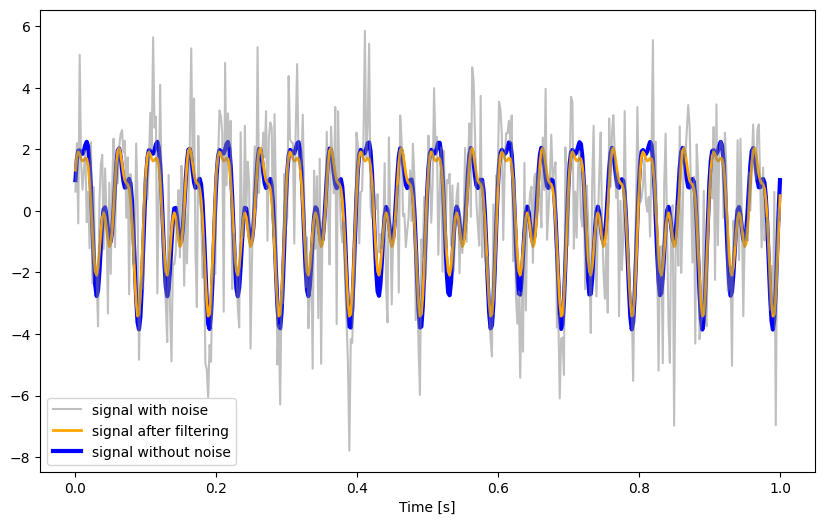

In [240]:
denoised_signal = np.fft.irfft(filtered_fft_signal_with_noise)

# Plot the noisy signal
plt.figure(figsize = (10,6))
plt.xlabel("Time [s]")
plt.plot(t_list, signal_with_noise, label = "signal with noise", color = "gray", alpha = 0.5);
plt.plot(t_list, denoised_signal, label = "signal after filtering",
         linewidth = 2, color = "orange", zorder = 1)
plt.plot(t_list, signal, label = "signal without noise",
         linewidth = 3, color = "blue", zorder = 0 )
plt.legend();